In [399]:
#Installing new libraries, random commands

#!pip install wordcloud
#!pip install TextBlob
#!pip install xgboost
#!pip install lightgbm
#print(sys.executable)
#!pip install imblearn

In [403]:
#Packages Required

#Basic
import pandas as pd
import numpy as np
import os
import sys
import warnings
warnings.filterwarnings("ignore")

#Data Viz
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from collections import Counter

#Text Processing
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
from sklearn.feature_extraction import text

#ML
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict
from imblearn.over_sampling import SMOTE

In [404]:
#Importing Data
df = pd.read_csv("Womens Clothing E-Commerce Reviews.csv")
df.shape

(23486, 11)

In [405]:
#Understand data structure
df.info() # need to drop the index 0 column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
Unnamed: 0                 23486 non-null int64
Clothing ID                23486 non-null int64
Age                        23486 non-null int64
Title                      19676 non-null object
Review Text                22641 non-null object
Rating                     23486 non-null int64
Recommended IND            23486 non-null int64
Positive Feedback Count    23486 non-null int64
Division Name              23472 non-null object
Department Name            23472 non-null object
Class Name                 23472 non-null object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In [406]:
df.sample(5)

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
9594,9594,941,42,Not soft,I had hoped this bulky knit would be cuddly an...,1,0,3,General,Tops,Sweaters
11957,11957,829,37,Great shirt,I have many maeve shirts and this one does not...,5,1,2,General,Tops,Blouses
10800,10800,1110,25,Perfect dress for work,Very flattering and flowy dress. would pair th...,4,1,0,General,Dresses,Dresses
8648,8648,828,57,Photo does not do this justice,1. i agree with the other reviewer. the photos...,4,1,3,General,Tops,Blouses
3851,3851,867,43,Poorly constructed and unflattering,"I ordered the taupe version of this tee, which...",1,0,4,General,Tops,Knits


In [407]:
#Preprocessing of df
#drop the index column and clothing id as it is not needed
df.drop(df.columns[[0,1]],inplace=True, axis=1) # inplace=True returns None and not a copy of the df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 9 columns):
Age                        23486 non-null int64
Title                      19676 non-null object
Review Text                22641 non-null object
Rating                     23486 non-null int64
Recommended IND            23486 non-null int64
Positive Feedback Count    23486 non-null int64
Division Name              23472 non-null object
Department Name            23472 non-null object
Class Name                 23472 non-null object
dtypes: int64(4), object(5)
memory usage: 1.6+ MB


In [408]:
#Check for missing values
df.isnull().sum()
#Review Text has the maximum number of missing values, followed by Div Name, Dept Name and Class Name equally

Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64

In [409]:
#Now, to understand the general trend of length of reviews, a length column will help with that
df['Review Length'] = df['Review Text'].astype(str).apply(len)

In [410]:
#As seen from rating vs recommended ind, even reviews 1 have been recommended, hence i generated another column as true percention of product
#I have considered a rating of 4 and above as a positive review ie True and 
# a rating of 2 and below as negative review ie 0
#I have ignored rating of 3 as i consider it to be neutral, and the analysis is about positive negative reviews classification

df = df[df['Rating'] != 3] #removing rows of rating 3
df['Perception of Product'] = df['Rating'] >=4
df.head(3)

,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Review Length,Perception of Product
0,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,53,True
1,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,303,True
3,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,124,True


In [411]:
#Remove missing values particularly from division name, class name, dept name as it wont aid in analysis.
#The review text column needs to be complete, hence missing values in those are dropped as well
#Title wont be for ML modeling, hence the column will be dropped altogether before ML modeling
for column in ["Class Name","Department Name","Division Name","Review Text"]:
    df = df[df[column].notnull()]
df.isnull().sum() #no more missing values in important columns for analysis

Age                           0
Title                      2607
Review Text                   0
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                 0
Department Name               0
Class Name                    0
Review Length                 0
Perception of Product         0
dtype: int64

In [412]:
#Check for unique values
df.nunique()

Age                           77
Title                      12129
Review Text                19798
Rating                         4
Recommended IND                2
Positive Feedback Count       78
Division Name                  3
Department Name                6
Class Name                    20
Review Length                495
Perception of Product          2
dtype: int64

**EDA**


In [413]:
df.describe() #describing new df

,Age,Rating,Recommended IND,Positive Feedback Count,Review Length
count,19805.000000,19805.000000,19805.000000,19805.000000,19805.000000
mean,43.442464,4.351729,0.876395,2.550972,306.101136
std,12.397537,1.093070,0.329139,5.633812,144.522035
min,18.000000,1.000000,0.000000,0.000000,9.000000
25%,34.000000,4.000000,1.000000,0.000000,183.000000
50%,41.000000,5.000000,1.000000,1.000000,298.000000
75%,52.000000,5.000000,1.000000,3.000000,454.000000
max,99.000000,5.000000,1.000000,117.000000,508.000000


**Sentiment Polarity**


A product represents the tone of the review or the sentiment as negative, positive and neutral tone.

TextBlob uses a sentiment lexicon (consisting of predefined words) to assign scores for each word, which are then averaged out using a weighted average to give an overall sentence sentiment score. Three scores: “polarity”, “subjectivity” and “intensity” are calculated for each word.

Each word in the lexicon has scores for:

    1. polarity: negative vs. positive    (-1 to +1)
    2. subjectivity: objective vs. subjective (0 to +1)
    3. intensity: modifies next word?      (0.5 to 2)
    
   Eg : 
   TextBlob("great").sentiment
   (polarity=0.8, subjectivity=0.75)
   
   TextBlob("not great").sentiment 
   Sentiment(polarity=-0.4, subjectivity=0.75)
   
Recognizing “very” as a modifier word, TextBlob will ignore polarity and subjectivity and just use intensity to modify the following word: 

TextBlob("very great").sentiment 
(polarity=1.0, subjectivity=0.9750000000000001)

The subjectivity is  modified by “very” to become higher.

Very few predictions are strongly negative or positive — this makes sense because TextBlob uses a weighted average sentiment score over all the words in each sample.In our data, a large number of texts belong to the neutral polarity. Hence it is clear that our TextBlob classifier predicts most samples as neutral



In [414]:
# Defining a sentiment analyser function for polarity
def sentiment(review):
    return review.apply(lambda Text: pd.Series(TextBlob(Text).sentiment.polarity))

In [415]:
# Applying function to reviews
df['Polarity'] = sentiment(df['Review Text'])
df.sample(5)

,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Review Length,Perception of Product,Polarity
3118,35,"Love, love, love",This has quickly become my go-to cardigan! it'...,5,1,0,General Petite,Tops,Fine gauge,238,True,0.518519
21129,29,Great style; runs small,Love the pattern on this lightweight cardigan ...,4,1,4,General Petite,Tops,Knits,330,True,0.287037
17961,50,Simple but pretty,Love this sweater! it is very simple but prett...,5,1,0,General,Tops,Fine gauge,97,True,0.322917
12369,38,Comfy and pretty and run 2 sizes too big.,"I'm always an xl in retailer blouses, and to b...",5,1,9,General,Tops,Knits,495,True,0.161922
5314,32,Cute but runs huge,I have been looking for a button-down denim sk...,4,1,4,General Petite,Bottoms,Skirts,500,True,0.142593


To understand how different polarities work across review texts, lets sample a few rows

In [416]:
pol = df.loc[df.Polarity == 1,['Review Text']].sample(5).values #Positive
print(pol)

[['This is a great blouse for all shapes!   you can wear it under a suit or with jeans!']
 ['Dress is awesome and makes you look skinnier.']
 ['Great purchase! i bought the coat to wear to work.']
 ['Great dress for vacations!']
 ['This is so flowing and perfect to hide any flaws.i adore it!']]


In [417]:
pol = df.loc[df.Polarity == 0.5,['Review Text']].sample(5).values #Neutral
print(pol)

[['Great sweater - heavy without being too warm. great layering piece.']
 ['I liked everything about this tunic except the way that it looked on me. the fabric was great - not too heavy, not too light. the design was cute and i loved the colors (i got the yellow). it was cut well, and a good length for me (i am 5\'2"). that being said, i am curvy and i felt like i looked even rounder in this top. if i was 6-8" taller it probably would have been perfect.']
 ['Love this dress. going to wear it for thanksgiving. love the material.']
 ['Fits like a maternity top. not for my age group or build.']
 ['I love this skirt. it fits perfectly. great to transition from work to after-work event. very comfy. got lots of complements.']]


In [418]:
pol =  df.loc[df.Polarity <0,['Review Text']].sample(5).values #Neutral
print(pol)

[['I have had my little eye on this dress since it came out! lucky me i found it sitting pretty in my local retailer lost   found! it runs a tad big, when i first tried it on with the sleeves off-the-shoulder i was disappointed in the length (past my knees); but i tried it on again with the sleeves sitting on my shoulders ... so so darling']
 ['This dress just fits weird. maybe it works for somebody..... there is a reason it has been put on sale...']
 ['Disappointed, the cut of the layer makes anyone wearing it look pregnant. even the model in the picture the way that layer hangs.']
 ['This dress is 100% rayon, not silk like the description says. that doesn\'t bother me that much because it\'s a really cute dress! it\'s also hand washable, which i like! i hate going to the dry cleaners! it fits true to size, and i know i will wear it for lots of occasions ? from casual to business. i almost always wear a small in retailer dresses and this one is the same. i\'m 5\'3" and the length hits


**Pre Processing of Text Data**



1. Text Cleaning
2. Using CountVectorizer


A major hiccup is that we cannot work with text directly when using machine learning algorithms. Therefore, its important to convert the text to numbers. Algorithms take vectors of numbers as input, hence we need to convert documents to fixed-length vectors of numbers.

The scikit-learn library offers easy-to-use tools to perform both tokenization and feature extraction of text data.

Therefore, CountVectorizer provides us with the number of times a word appears a text. It provides a way to tokenize and print a vocabulary of words. This can be done by assigning each word a unique number. Any text column can be encoded as a fixed-length vector with the length of the vocabulary of known words. The value in each position in the vector could be filled with a count or frequency of each word in the encoded document. An encoded vector is returned with a length of the entire vocabulary and an integer count for the number of times each word appeared in the document. The following are the steps involved in Vectorizing :

1. Create an instance of the CountVectorizer class.
2. Call the fit() function in order to learn a vocabulary from one or more documents.
3. Call the transform() function on one or more documents as needed to encode each as a vector.
4. Above two steps can be merged to one step

The vector returned from a call to transform() will have a lot of zeroes known as sparse vectors, and its important to transform it to numpy array so that we understand it better by calling the toarray() function.

 By default, CountVectorizer does the following:

- lowercases your text (set lowercase=false if you don’t want lowercasing)
- uses utf-8 encoding
- performs tokenization (converts raw text to smaller units of text)
- uses word level tokenization (meaning each word is treated as a separate token)
- ignores single characters during tokenization (say goodbye to words like ‘a’ and ‘I’)

Here, stop words are critical because if we remove the words that are very commonly used in a given language, we can focus on the important words instead and imporves the predictive power. CountVectorizer also provides in built English stop word list or we can create a corpus. I have used the inbuilt list.

In [419]:
stop_words = text.ENGLISH_STOP_WORDS

# Basic text cleaning function
def clean(text):
    
    text = text.astype(str) #String fn
        
    text = text.str.replace('\d+', '') #To remove numbers
    
    text = text.apply(lambda x: ' '.join([item for item in x.split() if item not in (stop_words)]))
    
    text = text.apply(lambda x: "".join([" " if ord(item) > 126 or ord(item) < 32 else item for item in x])) #Removing unicode chars
    
    text = text.str.replace('[^\w\s]', '') #Removing punctuation

    text = text.apply(lambda x: " ".join(x.strip() for x in x.split())) #Removing whitespaces
        
    return text

df['Review Text'] = clean(df['Review Text'])
df['Title'] = clean(df['Title'])
df.sample(5)

,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Review Length,Perception of Product,Polarity
22019,21,Love love love,I know lot folks thought bigboxy im pretty sli...,5,1,0,General,Tops,Blouses,500,True,0.213426
14452,33,The favorite,Love lace back its sweet typical tee comfy lit...,5,1,0,General,Tops,Knits,114,True,0.200347
16786,36,Cute,Cute top wish xxs looks great jeans fun neckla...,4,1,2,General Petite,Tops,Blouses,422,True,0.315833
2016,66,A step up,Very pleasantly surprised top its looser flowy...,5,1,0,General Petite,Tops,Knits,274,True,0.268006
1487,39,nan,Love pants retailer sell colors patterns these...,5,1,0,General,Bottoms,Pants,360,True,0.226718


In [420]:
#Vectorizing Data

#create transform fn with CountVectorizer() class
vectorizer = CountVectorizer()

#Return a callable that handles preprocessing, tokenization and n-grams generation.
#build_analyzer() returns a callable that let's you extract the tokenizing step from the transformation pipeline wrapped in the CountVectorizer
#applies preprocessing, tokenization, remove stop words and creates n-grams.
analyze = vectorizer.build_analyzer()

def count_of_words(x):
    a = {}
    if analyze(x):
        b = {}
        
        #This is equivalent to fit followed by transform, but more efficiently implemented.
        c = vectorizer.fit_transform([x]).toarray()
        # vocabulary and index
        d = vectorizer.vocabulary_
        for y,z in d.items():
            b[z]=y # index:word 
        for index,i in enumerate(c[0]):
            a[b[index]] = i # word:count
    return  a

df['Count of Words'] = df['Review Text'].apply(count_of_words)
df.head(3)

,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Review Length,Perception of Product,Polarity,Count of Words
0,33,nan,Absolutely wonderful silky sexy comfortable,4,1,0,Initmates,Intimate,Intimates,53,True,0.633333,"{'absolutely': 1, 'comfortable': 1, 'sexy': 1,..."
1,34,nan,Love dress its sooo pretty happened store im g...,5,1,4,General,Dresses,Dresses,303,True,0.339583,"{'bc': 2, 'bought': 1, 'definitely': 1, 'did':..."
3,50,My favorite buy,I love love love jumpsuit its fun flirty fabul...,5,1,0,General Petite,Bottoms,Pants,124,True,0.550000,"{'compliments': 1, 'fabulous': 1, 'flirty': 1,..."


**Exploratory Data Analysis**


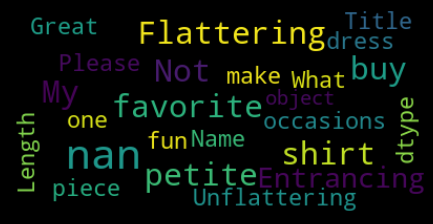

In [360]:
#Word Cloud for Title

import matplotlib as mpl
mpl.rcParams['font.size']=12                
mpl.rcParams['savefig.dpi']=100              
mpl.rcParams['figure.subplot.bottom']=.1 

stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                          background_color='black',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=40, 
                          random_state=12
                         ).generate(str(df['Title']))

fig = plt.figure(dpi=70, facecolor='k',edgecolor='k')
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

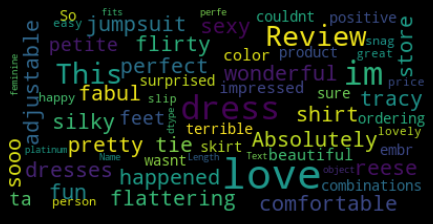

In [361]:
#Word Cloud for Review Text

import matplotlib as mpl
mpl.rcParams['font.size']=12                
mpl.rcParams['savefig.dpi']=100          
mpl.rcParams['figure.subplot.bottom']=.1 

stopwords = set(STOPWORDS)
wordcloud = WordCloud(
                          background_color='black',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=40, 
                          random_state=12
                         ).generate(str(df['Review Text']))

fig = plt.figure(dpi=70, facecolor='k',edgecolor='k')
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

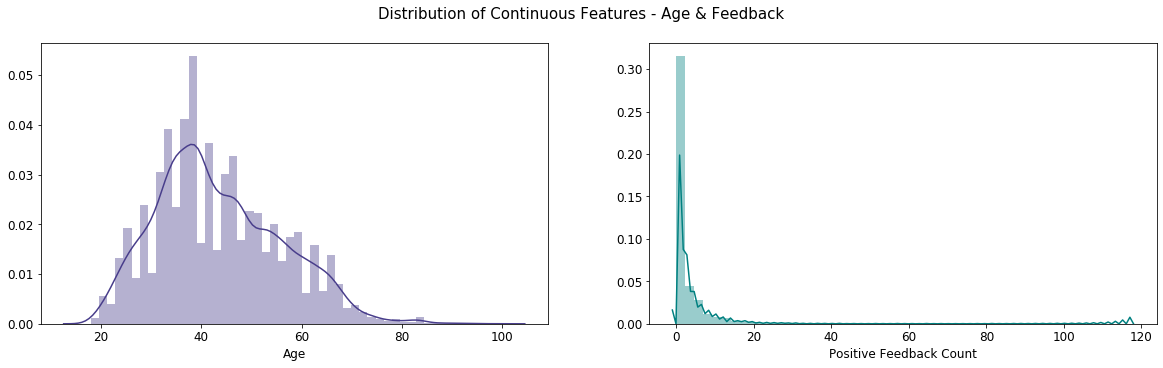

In [421]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.distplot(df["Age"], color="darkslateblue", ax=ax[0])
sns.distplot(df["Positive Feedback Count"], color = 'teal', ax=ax[1])
fig.suptitle('Distribution of Continuous Features - Age & Feedback', fontsize=15);

From the distribution of Categorical Variables, it can be seen the the data set is unbalanced as "Recommended IND" has more people recommedning products than people who dont recommend products on the website.

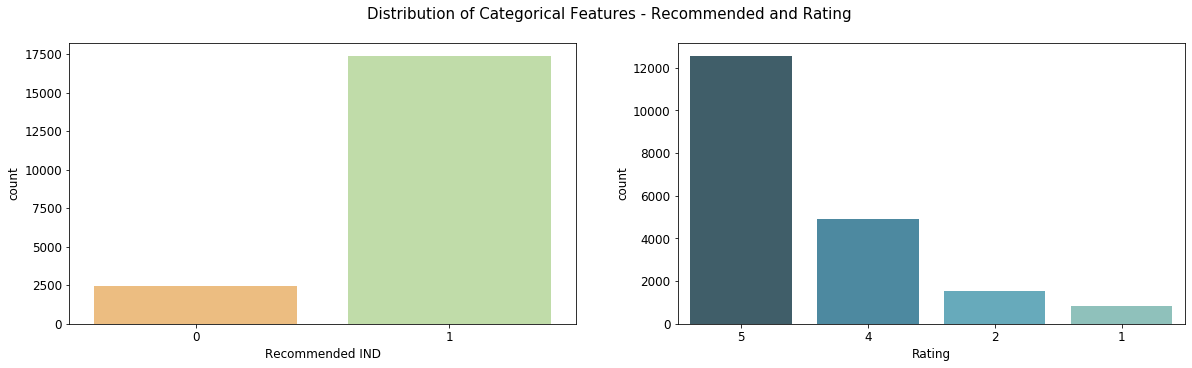

In [422]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.catplot(x="Recommended IND", kind = "count", palette=("Spectral"), data = df, ax=ax[0])
sns.catplot(x="Rating", kind = "count", palette=("GnBu_d"), data = df, order = df.Rating.value_counts().index, ax=ax[1])
fig.suptitle('Distribution of Categorical Features - Recommended and Rating', fontsize=15);
for i in range(2,4): 
    plt.close(i)

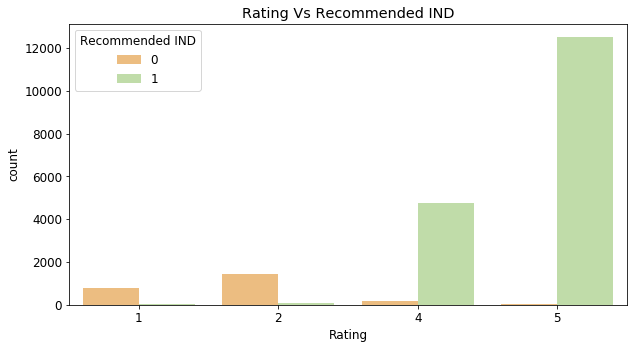

In [364]:
#Rating vs Recommended IND
plt.figure(figsize=(10,5))
sns.countplot(x="Rating", hue="Recommended IND",data=df, palette=("Spectral"))
plt.title("Rating Vs Recommended IND")
plt.show()

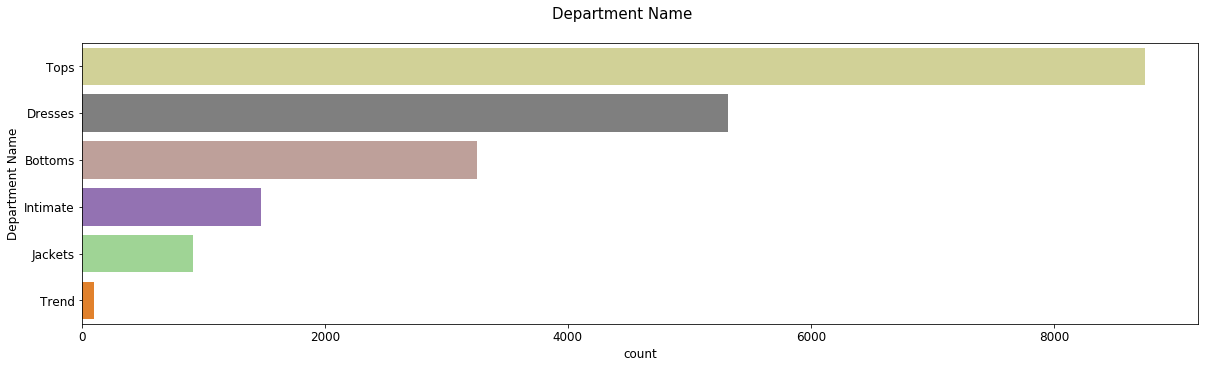

In [365]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
sns.countplot(y="Department Name", palette = "tab20_r",data=df, order=df["Department Name"].value_counts().index)
fig.suptitle('Department Name', fontsize=15);

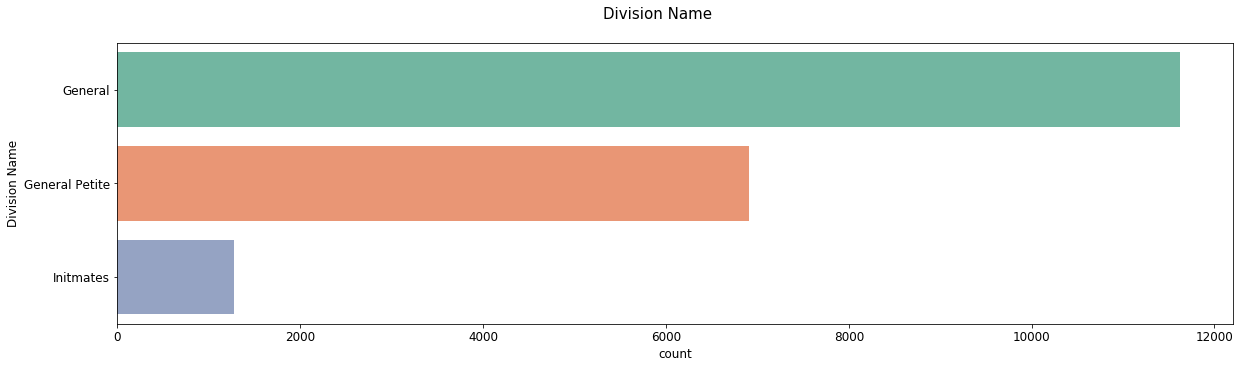

In [366]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
sns.countplot(y="Division Name", palette = "Set2",data=df, order=df["Division Name"].value_counts().index)
fig.suptitle('Division Name', fontsize=15);

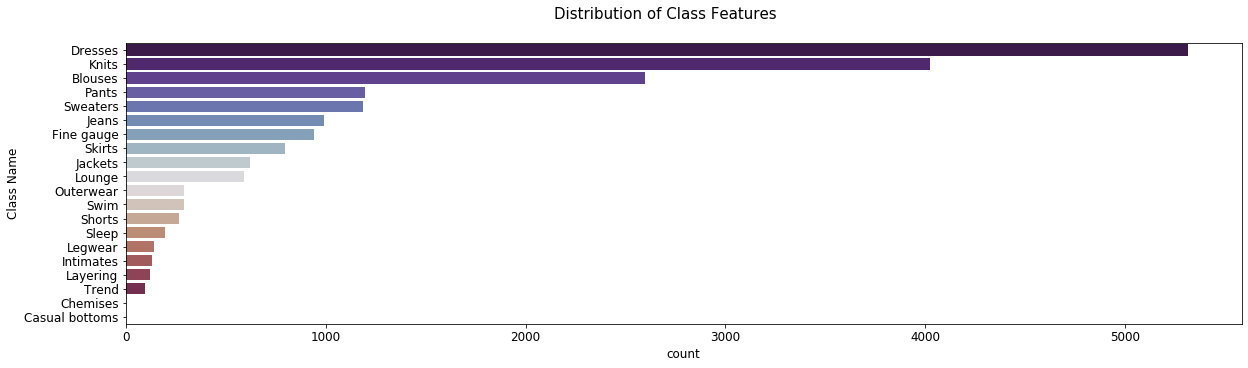

In [367]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
sns.countplot(y="Class Name", palette = "twilight_shifted", data=df, order=df["Class Name"].value_counts().index)
fig.suptitle('Distribution of Class Features', fontsize=15);

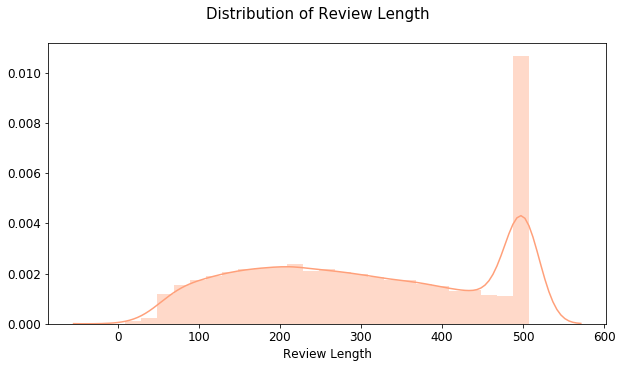

In [368]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
sns.distplot(df['Review Length'], color = "lightsalmon")
fig.suptitle('Distribution of Review Length', fontsize=15);

From the chart below, it can be seen that the users who gave a rating of 5, often wrote 500 plus word length reviews

**Identifying the Tone of the Reviews**

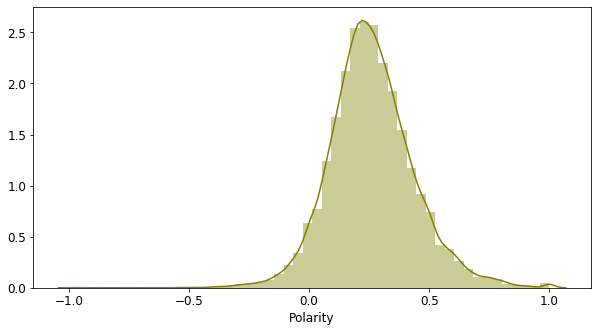

In [370]:
#Plotting Polarity
plt.figure(figsize=(10,5))
sns.distplot(df['Polarity'], color = 'olive');

In [371]:
#Plotting Polarity

neg = sum(1 for i in df.Polarity if i<0) 
pos = sum(1 for i in df.Polarity if i>0.5) 
neu = sum(1 for i in df.Polarity if i>0) 

data = {'Negative':[neg], 'Neutral':[neu], 'Positive':[pos]}

poldf = pd.DataFrame(data) 
print(poldf)

   Negative  Neutral  Positive
0       994    18734      1618


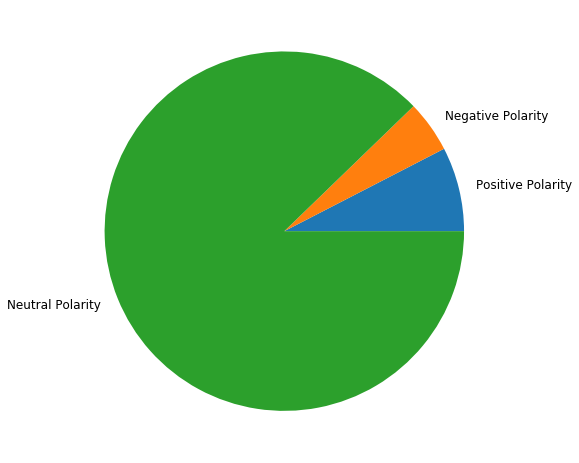

In [372]:
plt.figure(figsize =(10, 8)) 
plt.pie([pos,neg,neu], labels = ['Positive Polarity','Negative Polarity','Neutral Polarity']);

<Figure size 1440x360 with 0 Axes>

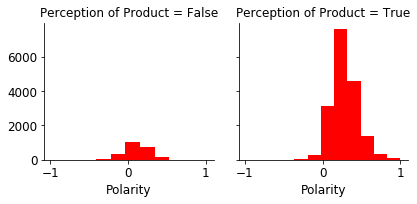

In [373]:
#Polarity vs Recommeneded IND
plt.figure(figsize=(20,5))
g = sns.FacetGrid(data=df, col='Perception of Product')
g.map(plt.hist, 'Polarity', color = "r", bins=10);

<Figure size 1440x360 with 0 Axes>

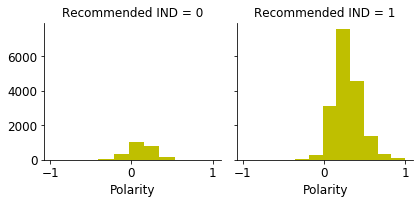

In [374]:
#Polarity vs Recommeneded IND - MOve this
plt.figure(figsize=(20,5))
g = sns.FacetGrid(data=df, col='Recommended IND')
g.map(plt.hist, 'Polarity', color = "y", bins=10);

**Feature Extraction : Machine learning Models**


**Spliting Data**

In [423]:
X = vectorizer.fit_transform(df['Review Text'])

In [424]:
y = df['Perception of Product']

In [425]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=12)
print('Train/Test Size : ', X_train.shape, X_test.shape, y_train.shape, y_test.shape)

Train/Test Size :  (14853, 17000) (4952, 17000) (14853,) (4952,)


**Models**

1. **Logistic Regression**

In [426]:
#Fitting Logistic Regression Model
lr = LogisticRegression(solver='liblinear')
lr.fit(X_train,y_train);

The accuracy score is 92.80000000000001


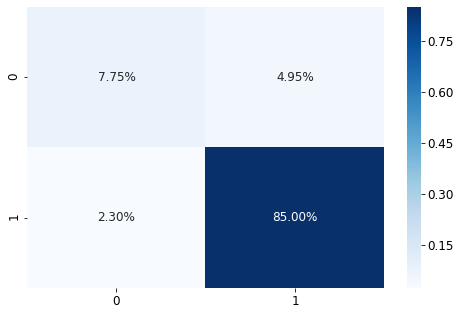

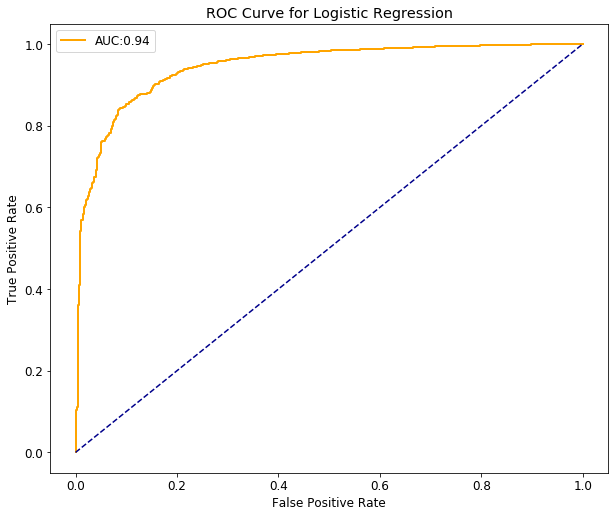

Classification Report for Logistic Regression:  
               precision    recall  f1-score   support

       False       0.77      0.61      0.68       629
        True       0.94      0.97      0.96      4323

    accuracy                           0.93      4952
   macro avg       0.86      0.79      0.82      4952
weighted avg       0.92      0.93      0.92      4952



In [427]:
#Accuracy Score
lr_score = accuracy_score(y_test,lr.predict(X_test))
print('The accuracy score is ' + str(round(lr_score,3)*100))

#Confusion Matrix
lr_matrix=confusion_matrix(y_test.values,lr.predict(X_test))
plt.figure(figsize=(8,5))
sns.heatmap(lr_matrix/np.sum(lr_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
x, y = plt.ylim()
x += 0.5
y -= 0.5
plt.ylim(x, y)
plt.show()

#ROC Curve
predict_lr = lr.predict_proba(X_test)[:,1]
fp_lr,tp_lr,th = roc_curve(y_test,predict_lr)
auc_lr = auc(fp_lr,tp_lr)

# Plotting the true positive and false positive rate
def plot_roc_curve(fpr, tpr):
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, label="AUC:%.2f" % (auc_lr), linewidth=2, c='orange')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Logistic Regression')
    plt.legend()
    plt.show()
plot_roc_curve(fp_lr, tp_lr)

#Classification Report
print("Classification Report for Logistic Regression:  \n",classification_report(y_test,lr.predict(X_test)))

Implementing Grid Search for Logistic Regression

In [428]:
# Grid search Logistic Regression

from sklearn.linear_model import LogisticRegression
grid={"C":np.logspace(0,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)
#Classification Report
print("Classification Report for Tuned Logistic Regression:  \n",classification_report(y_test,logreg_cv.predict(X_test)))

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'penalty': 'l2'}
accuracy : 0.9297115162391071
Classification Report for Tuned Logistic Regression:  
               precision    recall  f1-score   support

       False       0.77      0.61      0.68       629
        True       0.94      0.97      0.96      4323

    accuracy                           0.93      4952
   macro avg       0.86      0.79      0.82      4952
weighted avg       0.92      0.93      0.92      4952



2. **Naive Bayes**

The general term Naive Bayes refers the the strong independence assumptions in the model, rather than the particular distribution of each feature.

Multinomial Naive Bayes classifier is a specific instance of a Naive Bayes classifier which uses a multinomial distribution for each of the features.

BernoulliNB works for binary features such as 1,0 or  features that take only two values. In this case 0 means “negative rating or a negative perception of the product" occur in the document” and 1s as "word occurs in the document" 

In [429]:
#Fitting Naive Bayes Model

nb = BernoulliNB()
nb.fit(X_train,y_train);

The accuracy score is 89.5


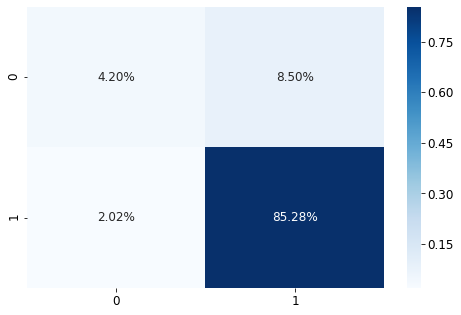

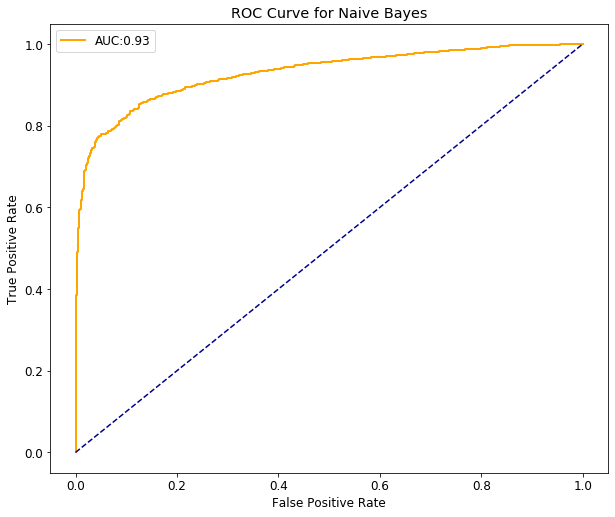

Classification Report for Naive Bayes:  
               precision    recall  f1-score   support

       False       0.68      0.33      0.44       629
        True       0.91      0.98      0.94      4323

    accuracy                           0.89      4952
   macro avg       0.79      0.65      0.69      4952
weighted avg       0.88      0.89      0.88      4952



In [430]:
#Accuracy Score
nb_score = accuracy_score(y_test,nb.predict(X_test))
print('The accuracy score is ' + str(round(nb_score,3)*100))

#Confusion Matrix
nb_matrix=confusion_matrix(y_test.values,nb.predict(X_test))
plt.figure(figsize=(8,5))
sns.heatmap(nb_matrix/np.sum(nb_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
x, y = plt.ylim()
x += 0.5
y -= 0.5
plt.ylim(x, y)
plt.show() 

#ROC Curve
predict_nb = nb.predict_proba(X_test)[:,1]
fp_nb,tp_nb,th = roc_curve(y_test,predict_nb)
auc_nb = auc(fp_nb,tp_nb)

# Plotting the true positive and false positive rate
def plot_roc_curve(fpr, tpr):
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, label="AUC:%.2f" % (auc_nb), linewidth=2, c='orange')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Naive Bayes')
    plt.legend()
    plt.show()
    
plot_roc_curve(fp_nb, tp_nb)

#Classification Report
print("Classification Report for Naive Bayes:  \n",classification_report(y_test,nb.predict(X_test)))

3. **SVM**

LinearSVC in comparision to SVC is more flexible and scalable implementation of SVC with linear kernel. The Linear SVC algorithm is much more efficient and can scale accordingly for large data sets otherwise SVC makes it hard to scale to dataset with more than a couple of 10000 samples and is inconsistent

In [431]:
#Fitting Support Vector Machine Model
#from sklearn.svm import LinearSVC
sv = LinearSVC()
sv.fit(X_train, y_train);

The accuracy score is 91.2


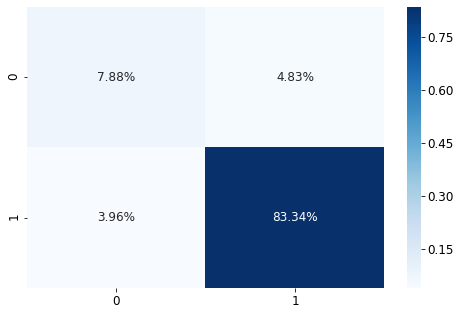

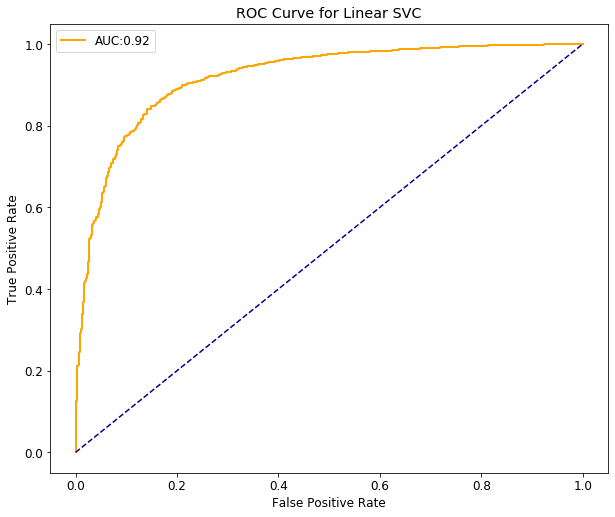

Classification Report for Support Vector Machine:  
               precision    recall  f1-score   support

       False       0.67      0.62      0.64       629
        True       0.95      0.95      0.95      4323

    accuracy                           0.91      4952
   macro avg       0.81      0.79      0.80      4952
weighted avg       0.91      0.91      0.91      4952



In [432]:
#Accuracy Score
sv_score = accuracy_score(y_test,sv.predict(X_test))
print('The accuracy score is ' + str(round(sv_score,3)*100))

#Confusion Matrix
sv_matrix=confusion_matrix(y_test.values,sv.predict(X_test))
plt.figure(figsize=(8,5))
sns.heatmap(sv_matrix/np.sum(sv_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
x, y = plt.ylim()
x += 0.5
y -= 0.5
plt.ylim(x, y)
plt.show() 

#ROC Curve
predict_sv = sv.decision_function(X_test)
fp_sv,tp_sv,th = roc_curve(y_test,predict_sv)
auc_sv = auc(fp_sv,tp_sv)

# Plotting the true positive and false positive rate
def plot_roc_curve(fpr, tpr):
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, label="AUC:%.2f" % (auc_sv), linewidth=2, c='orange')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Linear SVC')
    plt.legend()
    plt.show()
    
plot_roc_curve(fp_sv, tp_sv)

#Classification Report
print("Classification Report for Support Vector Machine:  \n",classification_report(y_test,sv.predict(X_test)))

Grid Search for SVC

In [433]:
#SVC Grid search

param_grid = {'C': [0.01, 0.1, 1.0, 10.0, 100.0]}
clf = GridSearchCV(LinearSVC(loss='hinge',random_state=12), param_grid)

#Fitting model
clf = clf.fit(X_train, y_train)

#Best param 
print ("Best parameters of the tuned model: %s" % clf.best_params_)

#Evaluation
print("Best cross-val score: {:.2f}".format(clf.best_score_))


#Classification Report
print("Classification Report for Tuned Support Vector Machine:  \n",classification_report(y_test,clf.predict(X_test)))

Best parameters of the tuned model: {'C': 0.1}
Best cross-val score: 0.93
Classification Report for Tuned Support Vector Machine:  
               precision    recall  f1-score   support

       False       0.77      0.58      0.66       629
        True       0.94      0.98      0.96      4323

    accuracy                           0.92      4952
   macro avg       0.86      0.78      0.81      4952
weighted avg       0.92      0.92      0.92      4952



4. **Random Forest**

In [434]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train);

The accuracy score is 89.3


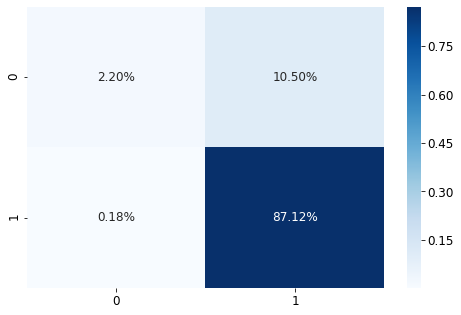

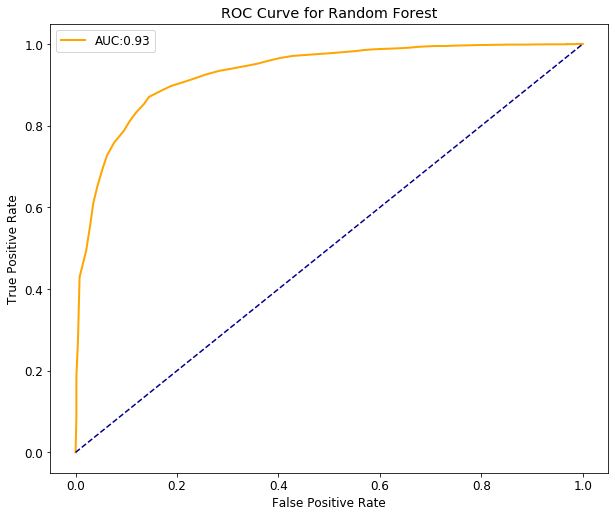

Classification Report for Random Forest:  
               precision    recall  f1-score   support

       False       0.92      0.17      0.29       629
        True       0.89      1.00      0.94      4323

    accuracy                           0.89      4952
   macro avg       0.91      0.59      0.62      4952
weighted avg       0.90      0.89      0.86      4952



In [435]:
#Accuracy Score
rf_score = accuracy_score(y_test,rf.predict(X_test))
print('The accuracy score is ' + str(round(rf_score,3)*100))

#Confusion Matrix
rf_matrix=confusion_matrix(y_test.values,rf.predict(X_test))
plt.figure(figsize=(8,5))
sns.heatmap(rf_matrix/np.sum(rf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
x, y = plt.ylim()
x += 0.5
y -= 0.5
plt.ylim(x, y)
plt.show() 

#ROC Curve
predict_rf = rf.predict_proba(X_test)[:,1]
fp_rf,tp_rf,th = roc_curve(y_test,predict_rf)
auc_rf = auc(fp_rf,tp_rf)

# Plotting the true positive and false positive rate
def plot_roc_curve(fpr, tpr):
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, label="AUC:%.2f" % (auc_rf), linewidth=2, c='orange')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Random Forest')
    plt.legend()
    plt.show()
    
plot_roc_curve(fp_rf, tp_rf)

#Classification Report
print("Classification Report for Random Forest:  \n",classification_report(y_test,rf.predict(X_test)))

Grid Search for Random Forest

In [436]:
#RF Grid Search
param_grid = {'n_estimators': [100, 200, 300],
               'max_depth': [1, 2, 3]}
rf_gc = GridSearchCV(RandomForestClassifier(random_state=12), param_grid, cv=5)
rf_gc.fit(X_train, y_train)

#Best param 
print ("Best parameters of the tuned model: %s" % rf_gc.best_params_)

#Evaluation
print("Best cross-val score: {:.2f}".format(rf_gc.best_score_))

#Classification Report
print("Classification Report for Tuned Random Forest:  \n",classification_report(y_test,rf_gc.predict(X_test)))

Best parameters of the tuned model: {'max_depth': 1, 'n_estimators': 100}
Best cross-val score: 0.88
Classification Report for Tuned Random Forest:  
               precision    recall  f1-score   support

       False       0.00      0.00      0.00       629
        True       0.87      1.00      0.93      4323

    accuracy                           0.87      4952
   macro avg       0.44      0.50      0.47      4952
weighted avg       0.76      0.87      0.81      4952



5. **XG Boosting**

In [437]:
xg = XGBClassifier()
xg.fit(X_train, y_train);

The accuracy score is 91.8


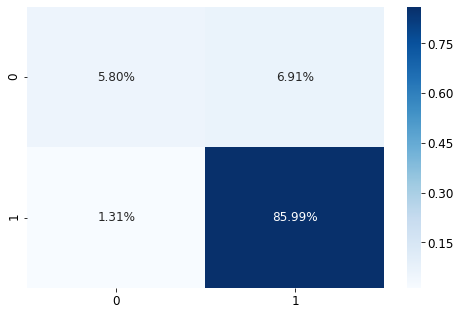

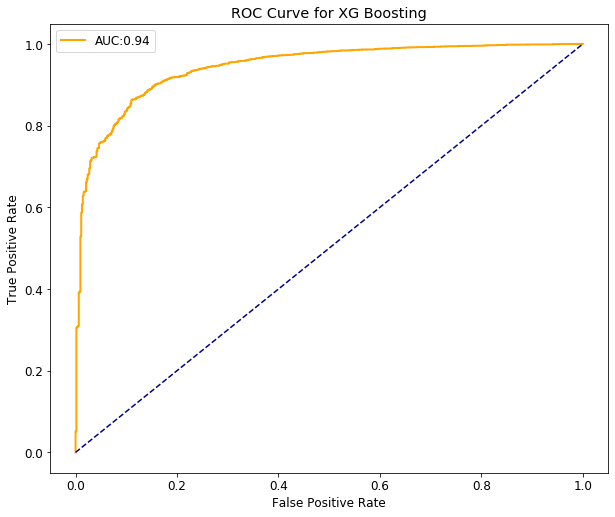

Classification Report:  
               precision    recall  f1-score   support

       False       0.82      0.46      0.59       629
        True       0.93      0.98      0.95      4323

    accuracy                           0.92      4952
   macro avg       0.87      0.72      0.77      4952
weighted avg       0.91      0.92      0.91      4952



In [438]:
#Accuracy Score
xg_score = accuracy_score(y_test,xg.predict(X_test))
print('The accuracy score is ' + str(round(xg_score,3)*100))

#Confusion Matrix
xg_matrix=confusion_matrix(y_test.values,xg.predict(X_test))
plt.figure(figsize=(8,5))
sns.heatmap(xg_matrix/np.sum(xg_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
x, y = plt.ylim()
x += 0.5
y -= 0.5
plt.ylim(x, y)
plt.show()

#ROC Curve
predict_xg = xg.predict_proba(X_test)[:,1]
fp_xg,tp_xg,th = roc_curve(y_test,predict_xg)
auc_xg = auc(fp_xg,tp_xg)

# Plotting the true positive and false positive rate
def plot_roc_curve(fpr, tpr):
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, label="AUC:%.2f" % (auc_xg), linewidth=2, c='orange')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for XG Boosting')
    plt.legend()
    plt.show()
    
plot_roc_curve(fp_xg, tp_xg)

#Classification Report
print("Classification Report:  \n",classification_report(y_test,xg.predict(X_test)))

6. **Ridge Regression**

In [439]:
from sklearn.linear_model import RidgeClassifier

ls = RidgeClassifier(alpha=0.01) # higher the alpha value, more restriction on the coefficients; low alpha > more generalization, coefficients are barely
ls.fit(X_train, y_train);

The accuracy score is 84.3


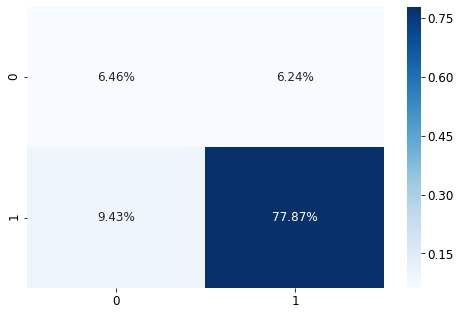

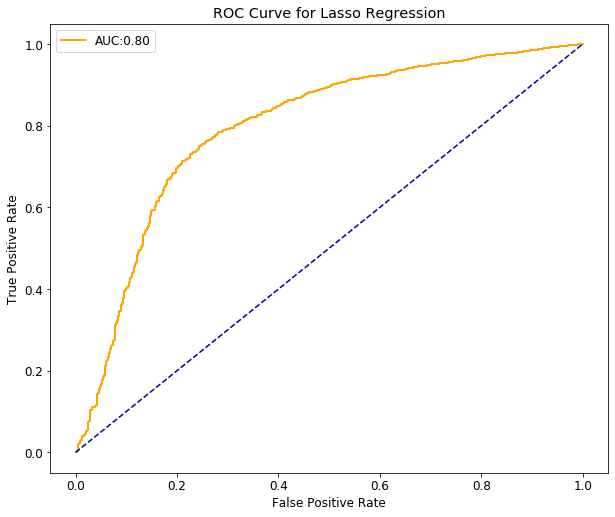

Classification Report for Ridge Regression:  
               precision    recall  f1-score   support

       False       0.41      0.51      0.45       629
        True       0.93      0.89      0.91      4323

    accuracy                           0.84      4952
   macro avg       0.67      0.70      0.68      4952
weighted avg       0.86      0.84      0.85      4952



In [440]:
#Accuracy Score
ls_score = accuracy_score(y_test,ls.predict(X_test))
print('The accuracy score is ' + str(round(ls_score,3)*100))

#Confusion Matrix
ls_matrix=confusion_matrix(y_test.values,ls.predict(X_test))
plt.figure(figsize=(8,5))
sns.heatmap(ls_matrix/np.sum(ls_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
x, y = plt.ylim()
x += 0.5
y -= 0.5
plt.ylim(x, y)
plt.show()

#ROC Curve

predict_ls = ls.decision_function(X_test)
fp_ls,tp_ls,th = roc_curve(y_test,predict_ls)
auc_ls = auc(fp_ls,tp_ls)

# Plotting the true positive and false positive rate
def plot_roc_curve(fpr, tpr):
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, label="AUC:%.2f" % (auc_ls), linewidth=2, c='orange')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Lasso Regression')
    plt.legend()
    plt.show()
    
plot_roc_curve(fp_ls, tp_ls)

#Classification Report
print("Classification Report for Ridge Regression:  \n",classification_report(y_test,ls.predict(X_test)))

References  

https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/

https://kavita-ganesan.com/how-to-use-countvectorizer/#Example-of-How-CountVectorizer-Works

https://towardsdatascience.com/fine-grained-sentiment-analysis-in-python-part-1-2697bb111ed4

**Rough Work Here on wards**